<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


<h1>Convolutional Neural Network with Batch-Normalization </h1> 


<h2>Table of Contents</h2>
<b>This lab takes a long time to run so the results are given. You can run the notebook your self but it may take a long time.</b>
<p>In this lab, we will compare a Convolutional Neural Network using Batch Normalization with a regular Convolutional Neural Network  to classify handwritten digits from the MNIST database. We will reshape the images to make them faster to process. </p>

<ul>
    <li><a href="#read_me">Read me Batch Norm for Convolution Operation  </a></li>
<li><a href="#Makeup_Data">Get Some Data</a></li>
<li><a href="#CNN">Two Types of Convolutional Neural Network</a></li>
<li><a href="#Train">Define Criterion function, Optimizer and Train the Model</a></li>
<li><a href="#Result">Analyze Results</a></li>
</ul>

<hr>


<h2 id="read_me">Read me Batch Norm for Convolution Operation  </h2>


Like a fully connected network, we create a <code>BatchNorm2d</code> object, but we apply it to the 2D convolution object. First, we create objects <code>Conv2d</code> object; we require the number of output channels, specified by the variable <code>OUT</code>.  


<code>self.cnn1 = nn.Conv2d(in_channels=1, out_channels=OUT, kernel_size=5, padding=2) </code>


We then create a Batch Norm  object for 2D convolution as follows:


<code>self.conv1_bn = nn.BatchNorm2d(OUT)</code>


The parameter out is the number of channels in the output. We can then apply batch norm  after  the convolution operation:

<code>x = self.cnn1(x)</code>
<p></p>

<code>x=self.conv1_bn(x)</code>
<p></p>


<h2>Preparation</h2>


In [1]:
# Using the following line code to install the torchvision library
# !mamba install -y torchvision

# !pip install torchvision==0.9.1 torch==1.8.1

import matplotlib.pylab as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import DataLoader

def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap = 'gray')
    plt.title('y = '+ str(data_sample[1]))

<h2 id="Makeup_Data">Get the Data</h2> 


In [2]:
# Create transform to resize the image and convert it to a tensor

IMAGE_SIZE = 16

composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

Load the training dataset by setting the parameters <code>train </code> to <code>True</code>. We use the transform defined above.


In [3]:
# Load the training and validating dataset
train_dataset = dsets.MNIST(root = './data', train = True, 
                            download = True, transform = composed)
validation_dataset = dsets.MNIST(root = './data', train = False, 
                                 download = True, transform = composed)

In [4]:
# Show the data type for each element in dataset

type(train_dataset[0][1])

int

Each element in the rectangular tensor corresponds to a number representing a pixel intensity as demonstrated by the following image.


<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.2.1imagenet.png" width="550" alt="MNIST data image">


In [5]:
# The label for 4th data element

train_dataset[3][1]

1

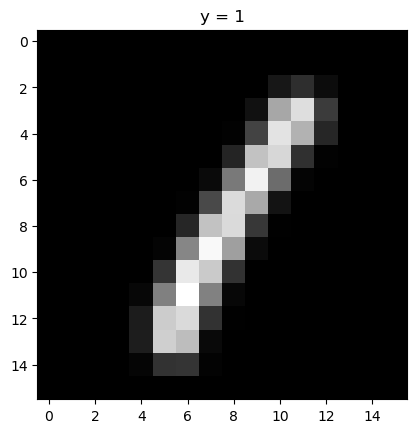

In [6]:
# The image for 4th data element
show_data(train_dataset[3])


<h2 id="CNN">Build a Two Convolutional Neural Network Class</h2>


Build a Convolutional Network class with 2 convolutional layers and 1 fully connected layer. Pre-determine the size of the final output matrix. The parameters in the constructor are the number of output channels for the first and second layer.

In [7]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1 = 16, out_2 = 32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 1, out_channels = out_1,
                              kernel_size = 5, padding = 2)
        self.maxpool1=nn.MaxPool2d(kernel_size = 2)

        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2,
                              kernel_size = 5, stride = 1, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [8]:
class CNN_batch(nn.Module):
    
    # Contructor
    def __init__(self, out_1 = 16, out_2 = 32, number_of_classes = 10):
        super(CNN_batch, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 1, out_channels = out_1,
                              kernel_size = 5, padding = 2)
        self.conv1_bn = nn.BatchNorm2d(out_1)

        self.maxpool1=nn.MaxPool2d(kernel_size = 2)
        
        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2,
                              kernel_size = 5, stride = 1, padding = 2)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn_fc1(x)
        return x

In [9]:
# Function to train the model

def train_model(model, train_loader,
                validation_loader, optimizer, n_epochs = 4):
    
    # global variable 
    N_test = len(validation_dataset)
    accuracy_list = []
    loss_list = []
    for epoch in range(n_epochs):
        for x, y in train_loader:
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.data)

        correct = 0
        # perform prediction on the validation data
        for x_test, y_test in validation_loader:
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
     
    return accuracy_list, loss_list

<h2 id="Train">Define the Convolutional Neural Network Classifier, Criterion function, Optimizer and Train the Model</h2> 


In [10]:
# Create the model object using CNN class
model = CNN(out_1 = 16, out_2 = 32)

In [11]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

train_loader = DataLoader(dataset = train_dataset, batch_size = 100)
validation_loader = DataLoader(dataset = validation_dataset, batch_size = 5000)

In [12]:
# Train the model and determine validation accuracy -- technically test accuracy.
# This may take a long time!
accuracy_list_normal, loss_list_normal = train_model(
    model = model, n_epochs = 10,train_loader = train_loader,
    validation_loader = validation_loader, optimizer = optimizer)

In [13]:
# Repeat the Process for the model with batch norm

model_batch = CNN_batch(out_1 = 16, out_2 = 32)
criterion = nn.CrossEntropyLoss()

learning_rate = 0.1
optimizer = torch.optim.SGD(model_batch.parameters(), lr = learning_rate)
accuracy_list_batch, loss_list_batch = train_model(
    model = model_batch, n_epochs = 10,
    train_loader = train_loader, validation_loader = validation_loader, optimizer = optimizer)

<h2 id="Result">Analyze Results</h2> 


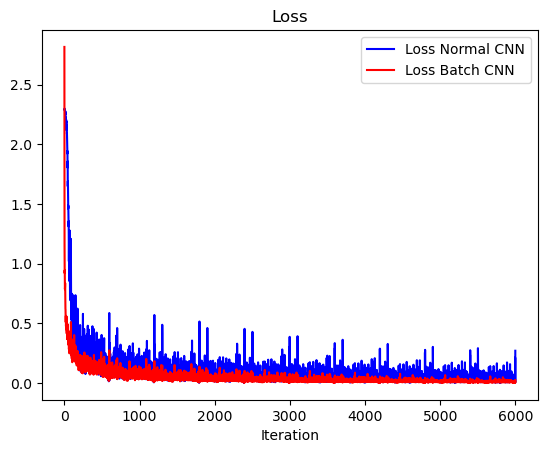

In [14]:
# Plot the loss and accuracy

plt.plot(loss_list_normal, 'b', label = 'Loss Normal CNN')
plt.plot(loss_list_batch, 'r', label = 'Loss Batch CNN')
plt.xlabel('Iteration')
plt.title('Loss')
plt.legend()
plt.show()

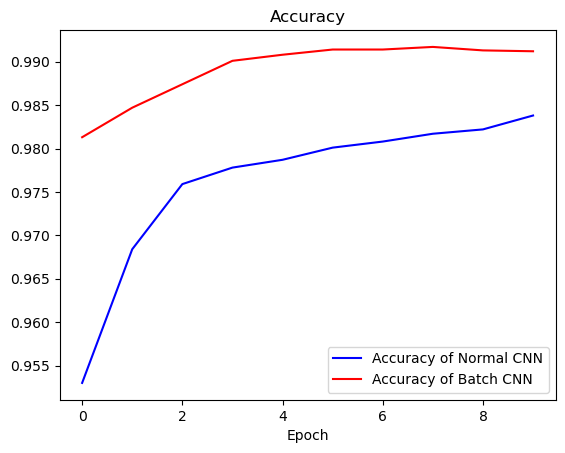

In [15]:
plt.plot(accuracy_list_normal, 'b', label = 'Accuracy of Normal CNN')
plt.plot(accuracy_list_batch, 'r', label = 'Accuracy of Batch CNN')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend()
plt.show()

**The CNN w/ batch normalization performs better with faster convergence.**
